In [1]:
%cd yolov5

E:\sugarcane_bud_classification\yolov5


C:\Users\smsan\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pathlib
import sys
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Fix WindowsPath loading issue
if sys.platform != "win32":
    pathlib.WindowsPath = pathlib.PosixPath

# Load YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='E:\\sugarcane_bud_classification\\best.pt', force_reload=True)

# Load MobileNet classification model
mobilenet_model = load_model("E:\\sugarcane_bud_classification\\mobilenetv1_sugarcane_bud_classifier.h5")

# Classification labels
class_names = ['Grade A', 'Grade B', 'Grade C']

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\smsan/.cache\torch\hub\master.zip
YOLOv5  2025-6-6 Python-3.12.6 torch-2.4.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


In [3]:
%matplotlib inline

In [4]:
def detect_and_classify_buds(image_path):
    img_pil = Image.open(image_path)
    img_cv2 = cv2.imread(image_path)
    img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

    results = yolo_model(img_pil)
    detections = results.pandas().xyxy[0]

    grades = []

    for i, row in detections.iterrows():
        x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

        crop = img_cv2_rgb[y1:y2, x1:x2]
        crop_resized = cv2.resize(crop, (224, 224))
        image_array = img_to_array(crop_resized)
        image_array = preprocess_input(image_array)
        image_array = np.expand_dims(image_array, axis=0)

        preds = mobilenet_model.predict(image_array, verbose=0)
        class_index = np.argmax(preds[0])
        predicted_class = class_names[class_index]

        grades.append(predicted_class)

        # Draw bounding box
        cv2.rectangle(img_cv2_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)  # thicker box

        # Draw label with bigger font
        font_scale = 2  # Increased font size
        thickness = 3
        label = predicted_class
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        label_ymin = max(y1, label_size[1] + 10)
        cv2.rectangle(img_cv2_rgb, (x1, label_ymin - label_size[1] - 10), 
                      (x1 + label_size[0], label_ymin), (0, 255, 0), cv2.FILLED)
        cv2.putText(img_cv2_rgb, label, (x1, label_ymin - 7), 
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)

    # Show the final image after all boxes are drawn
    plt.figure(figsize=(16, 12))  # Bigger display size
    plt.imshow(img_cv2_rgb)
    plt.axis('off')
    plt.show()

    return grades

C:\Users\smsan/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


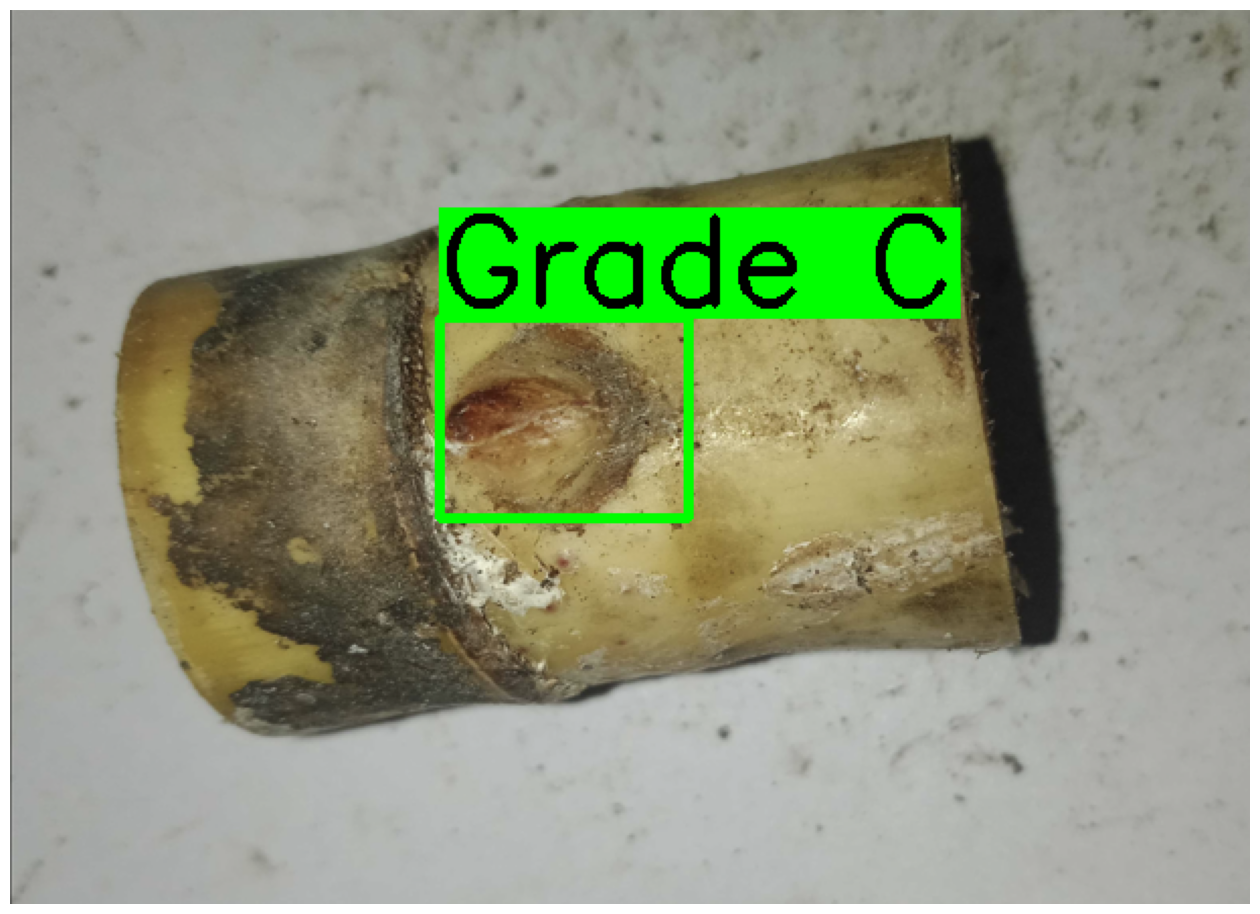

In [9]:
grades = detect_and_classify_buds(r"E:\sugarcane_bud_classification\grade3\Picture1.png") 